# **Setup**

* https://machinelearningmastery.com/mastering-time-series-forecasting-from-arima-to-lstm/
* https://www.kaggle.com/datasets/shenba/time-series-datasets

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input 

# **Data Import**

In [15]:
# Load your dataset
df = pd.read_csv('Electric_Production.csv',parse_dates=['DATE'], index_col='DATE')
df.rename(columns={'IPG2211A2N':'Production'},inplace=True)
df.head()

,Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


# **Data Processing**

In [16]:
from statsmodels.tsa.stattools import adfuller

# ADF Test to check for stationarity
result = adfuller(df['Production'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] > 0.05:
    print("The series is non-stationary. Differencing is needed.")
else:
    print("The series is stationary.")

ADF Statistic: -2.25699035004725
p-value: 0.18621469116586592
The series is non-stationary. Differencing is needed.


In [17]:
# First Order Differencing Transformation For Stationarity
df['Differenced'] = df['Production'].diff()

# Drop missing values resulting from differencing
df.dropna(inplace=True)

# Display the first few rows of the differenced data
print(df[['Production', 'Differenced']].head())

            Production  Differenced
DATE                               
1985-02-01     70.6720      -1.8332
1985-03-01     62.4502      -8.2218
1985-04-01     57.4714      -4.9788
1985-05-01     55.3151      -2.1563
1985-06-01     58.0904       2.7753


In [20]:
df.tail()

,Production,Differenced
DATE,,
2017-09-01,98.6154,-10.3158
2017-10-01,93.6137,-5.0017
2017-11-01,97.3359,3.7222
2017-12-01,114.7212,17.3853
2018-01-01,129.4048,14.6836


# **ARIMA Model**

3 Components
- AutoRegressive (AR): The relationship between an observation and a number of lagged observations
- Integrated (I): The differencing of raw observations to allow for the time series to become stationary
- Moving Average (MA): The relationship shows how an observation differs from the predicted value in a moving average model using past data

In [25]:
# Fit the ARIMA model
model = ARIMA(df['Production'], order=(1, 1, 1))
model_fit = model.fit()

# Forecasting next steps
forecast = model_fit.forecast(steps=36)
forecast.head()

c:\Users\aksha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aksha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\aksha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2018-02-01    133.483245
2018-03-01    133.785491
2018-04-01    133.807890
2018-05-01    133.809550
2018-06-01    133.809673
Freq: MS, Name: predicted_mean, dtype: float64

C:\Users\aksha\AppData\Local\Temp\ipykernel_14876\148265335.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(df.index[-1], periods=36, freq='M'),forecast, label='Forecasted Production', color='red')


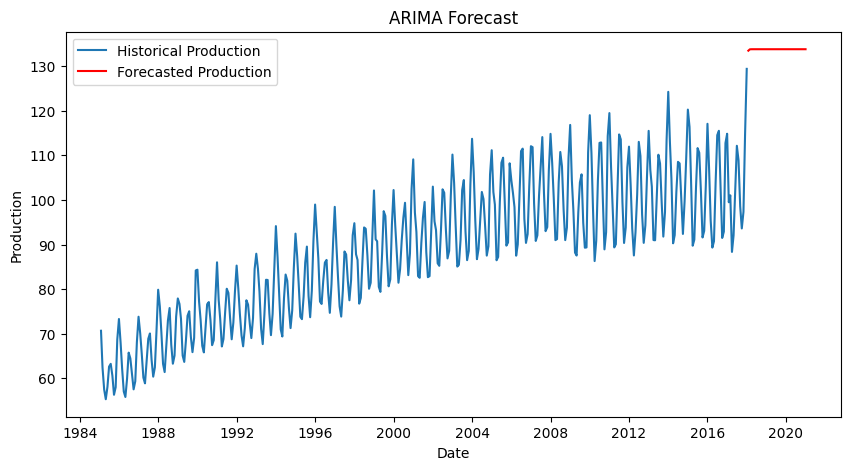

In [30]:
# Plotting the forecast
plt.figure(figsize=(10, 5))
plt.plot(df['Production'], label='Historical Production')
plt.plot(pd.date_range(df.index[-1], periods=36, freq='M'),forecast, label='Forecasted Production', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

# **ETS Model**

Exponential smoothing is a method used for time series forecasting. It includes three components:

- Error (E): Represents the unpredictability or noise in the data
- Trend (T): Shows the long-term direction of the data
- Seasonality (S): Captures repeating patterns or cycles in the data

We will use the Holt-Winters method for performing ETS. ETS helps us predict data that has both trends and seasons.

c:\Users\aksha\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2018-02-01    115.403529
2018-03-01    109.354245
2018-04-01     98.091388
2018-05-01    100.620492
2018-06-01    111.865329
Freq: MS, dtype: float64

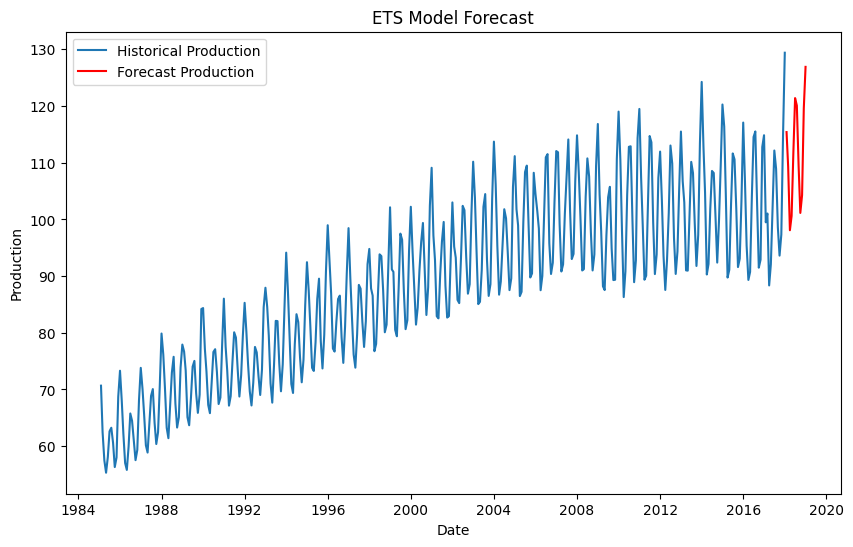

In [34]:
# Fit the ETS model (Exponential Smoothing)
ets_model = ExponentialSmoothing(df['Production'], seasonal='add', trend='add', seasonal_periods=12)
ets_fit = ets_model.fit()

# Forecasting the next 12 periods 
forecast_ets = ets_fit.forecast(steps=12)
display(forecast_ets.head())

# Plot observed and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df['Production'], label='Historical Production')
plt.plot(forecast_ets, label='Forecast Production', color='red')
plt.title('ETS Model Forecast')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()

# **LSTM Model**

In [39]:
# Extract the values of the target column
data = df['Production'].values
data = data.reshape(-1, 1)

print(data.shape)
data[:10]

(396, 1)


array([[70.672 ],
       [62.4502],
       [57.4714],
       [55.3151],
       [58.0904],
       [62.6202],
       [63.2485],
       [60.5846],
       [56.3154],
       [58.0005]])

In [41]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
 
# Display the first few scaled values
print(scaled_data[:5])

[[0.20727443]
 [0.09630353]
 [0.02910391]
 [0.        ]
 [0.03745865]]


In [42]:
# Create a function to convert data into sequences for LSTM
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

# Use 60 time steps to predict the next value
time_steps = 60
X, y = create_sequences(scaled_data, time_steps)

# Reshape X for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

In [43]:
# Split the data into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [46]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

# Define the LSTM model
model = Sequential()
model.add(Input(shape=(time_steps, 1))) # Input layer
model.add(LSTM(50, return_sequences=True)) # LSTM layer with 50 units
model.add(Dense(1)) # Output layer
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Display the first few predicted and actual values
print(y_pred_rescaled[:5])
print(y_test_rescaled[:5])

Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1743 - val_loss: 0.0597
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0559 - val_loss: 0.0407
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0531 - val_loss: 0.0453
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0478 - val_loss: 0.0399
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0426 - val_loss: 0.0347
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0411 - val_loss: 0.0375
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0391 - val_loss: 0.0400
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0377 - val_loss: 0.0363
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0364 - val_loss: 0.0440
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0350 - val_loss: 0.0382
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0336 - val_loss: 0.0456
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0345 - val_loss: 0.0424
E

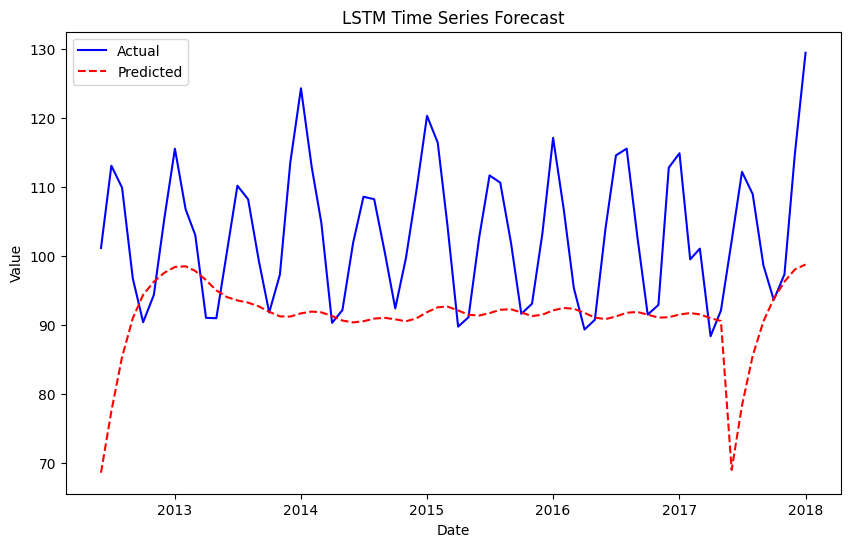

In [49]:
# Plot the actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(df.index[-len(y_test_rescaled):], y_test_rescaled, label='Actual', color='blue')
plt.plot(df.index[-len(y_test_rescaled):], y_pred_rescaled[:len(y_test_rescaled)], label='Predicted', color='red', linestyle='dashed')
plt.title('LSTM Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()